In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from src.utils_contributions import *
import torch.nn.functional as F
from src.contributions import ModelWrapper, ClassificationModelWrapperCaptum, interpret_sentence_sst2
import pandas as pd
import h5py
import json
import random
random.seed(10)

torch.cuda.set_device(3)
torch.cuda.current_device()

from collections import defaultdict
import statistics

import codecs, json

import nltk
from nltk.corpus import stopwords

import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.cuda.set_device(3)
torch.cuda.current_device()

3

## Load model and tokenizer (BERT, DistilBERT, RoBERTa)

In [3]:
model_name = 'distilbert'
dataset_name = 'sst2'
model, tokenizer, dataset_partition = load_model_data(model_name,dataset_name)

Loading distilbert ...
Loading sst2 ...


Reusing dataset glue (/home/usuaris/veu/javier.ferrando/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


### Load dataset

In [20]:
sentence = dataset_partition[17] #403, 17, 1360, 1453, 1815
# short -> 54
if dataset_name == 'sst2':
    text = sentence['sentence']

elif dataset_name == 'imdb':
    text = sentence['text']

In [21]:
# for i, sentence in enumerate(dataset_partition):
#     text = sentence['sentence']
#     if len(text)<60 and len(text)>20:
#         print(i)
#         print(text)

## Tokenize text

In [22]:
print(text)
pt_batch = tokenizer(text, return_tensors="pt").to(device)
tokenized_text = tokenizer.convert_ids_to_tokens(pt_batch["input_ids"][0])
print(tokenized_text)
seq_len = len(tokenized_text)

a remarkable 179-minute meditation on the nature of revolution .
['[CLS]', 'a', 'remarkable', '179', '-', 'minute', 'meditation', 'on', 'the', 'nature', 'of', 'revolution', '.', '[SEP]']


## Forward pass

In [23]:
model_wrapped = ModelWrapper(model)
#prediction_scores, hidden_states, attentions, transformed_vectors_norm_model, contributions, transformed_vectors = model_wrapped(pt_batch)
prediction_scores, hidden_states, attentions, contributions_data = model_wrapped(pt_batch)

probs = torch.nn.functional.softmax(prediction_scores, dim=-1)
print('probs',probs)
pred_ind = torch.argmax(probs)
pred = torch.max(probs)
pred

probs tensor([[1.5582e-04, 9.9984e-01]], device='cuda:3')


tensor(0.9998, device='cuda:3')

In [24]:
# LayerNorm = model.bert.encoder.layer[10].attention.output.LayerNorm
# ln_weight = LayerNorm.weight.cpu().detach().numpy()
# fig = plt.figure(figsize =(20,4))
# ax = fig.add_subplot(111)
# ax.bar(range(0,ln_weight.size),ln_weight)
# plt.xticks(ticks = range(0,ln_weight.size) ,labels = text, rotation = 45);

### Getting attention weights (attentions_mat), attention vector norms (model_norms) and contributions from our method (contributions)

In [25]:
_attentions = [att.detach().cpu().numpy() for att in attentions]
attentions_mat = np.asarray(_attentions)[:,0] # (num_layers,num_heads,src_len,src_len)
att_mat_sum_heads = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
print(att_mat_sum_heads.shape)
normalized_model_norms = normalize_contributions(contributions_data['transformed_vectors_norm'],scaling='sum_one')
resultant_norm = resultants_norm = torch.norm(torch.squeeze(contributions_data['resultants']),p=1,dim=-1)
normalized_contributions = normalize_contributions(contributions_data['contributions'],scaling='min_sum',resultant_norm=resultant_norm)


(6, 14, 14)


### Rollout with attention weights (Abnar and Zuidema, 2020)

In [26]:
joint_attention_rollout = compute_rollout(att_mat_sum_heads)
joint_attention_rollout_cls = joint_attention_rollout[-1][0]
joint_attention_rollout = joint_attention_rollout.cpu().detach().numpy()

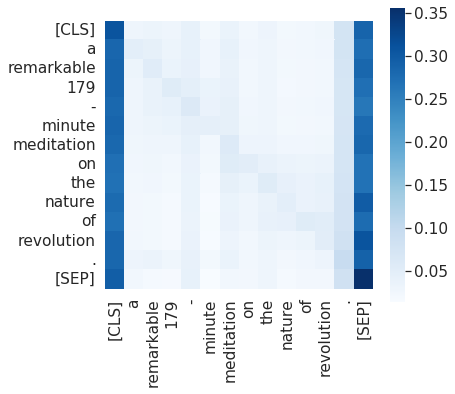

In [27]:
layer = -1
plt.figure(figsize=(6,6))
df = pd.DataFrame(joint_attention_rollout[layer],columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Blues",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### Attention rollout + |T(x_j)| (Kobayashi et al., 2021)

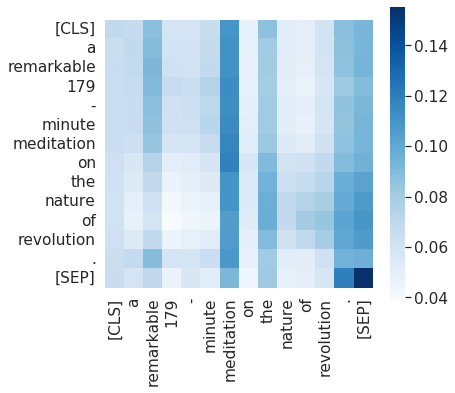

In [28]:
norms_mix = compute_joint_attention(normalized_model_norms)
norm_rollout_cls = norms_mix[-1][0]
norms_mix = norms_mix.detach().cpu().numpy()
plt.figure(figsize=(6,6))
joint_attention_layer = -1
df = pd.DataFrame(norms_mix[joint_attention_layer],columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Blues",square=True)
plt.gcf().subplots_adjust(bottom=0.2)


### Our approach

torch.float32


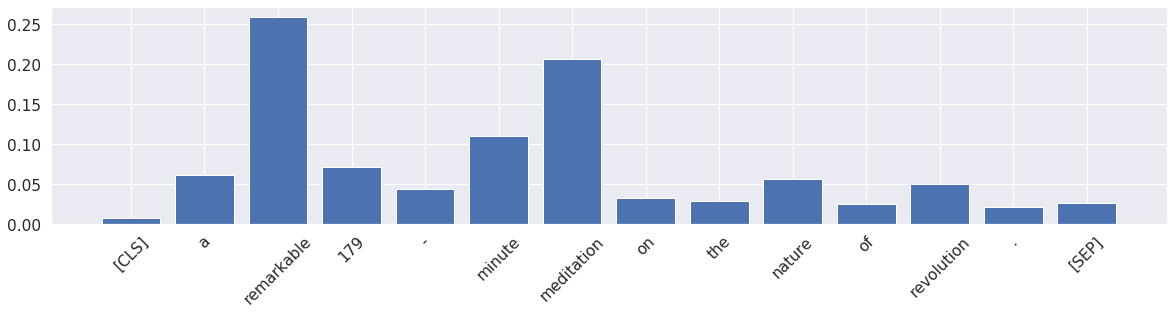

In [29]:
print(normalized_contributions.dtype)
contributions_mix = compute_joint_attention(normalized_contributions)
joint_attention_layer = -1
pos=0
contributions_mix_cls = contributions_mix[joint_attention_layer][pos]
plot_histogram(contributions_mix_cls,tokenized_text)


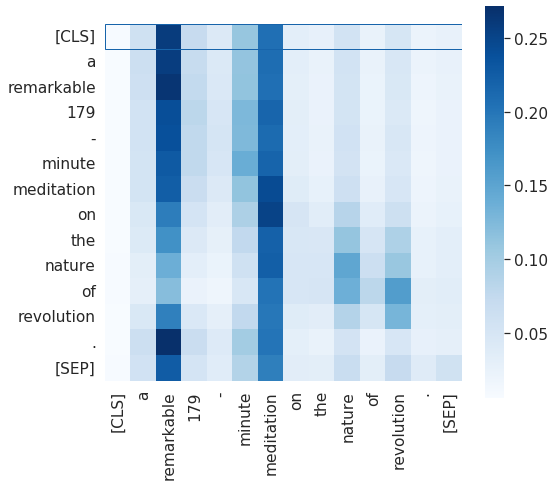

In [30]:
contributions_mix = compute_joint_attention(normalized_contributions)
contributions_mix = contributions_mix.detach().cpu().numpy()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

from matplotlib.patches import Rectangle

#joint_attention_normalized_layer = contributions_mix[joint_attention_layer] / joint_attentions[joint_attention_layer].sum(axis=-1)[...,None]
df = pd.DataFrame(contributions_mix[joint_attention_layer],columns=tokenized_text,index=tokenized_text)
sns.set(font_scale=1.4)
sns.heatmap(df, cmap="Blues", square=True, ax = ax)#Reds,,center=0
ax.add_patch(Rectangle((0, 0), seq_len, 1, fill=False, edgecolor='#1764AB', lw=1))
plt.gcf().subplots_adjust(bottom=0.2)


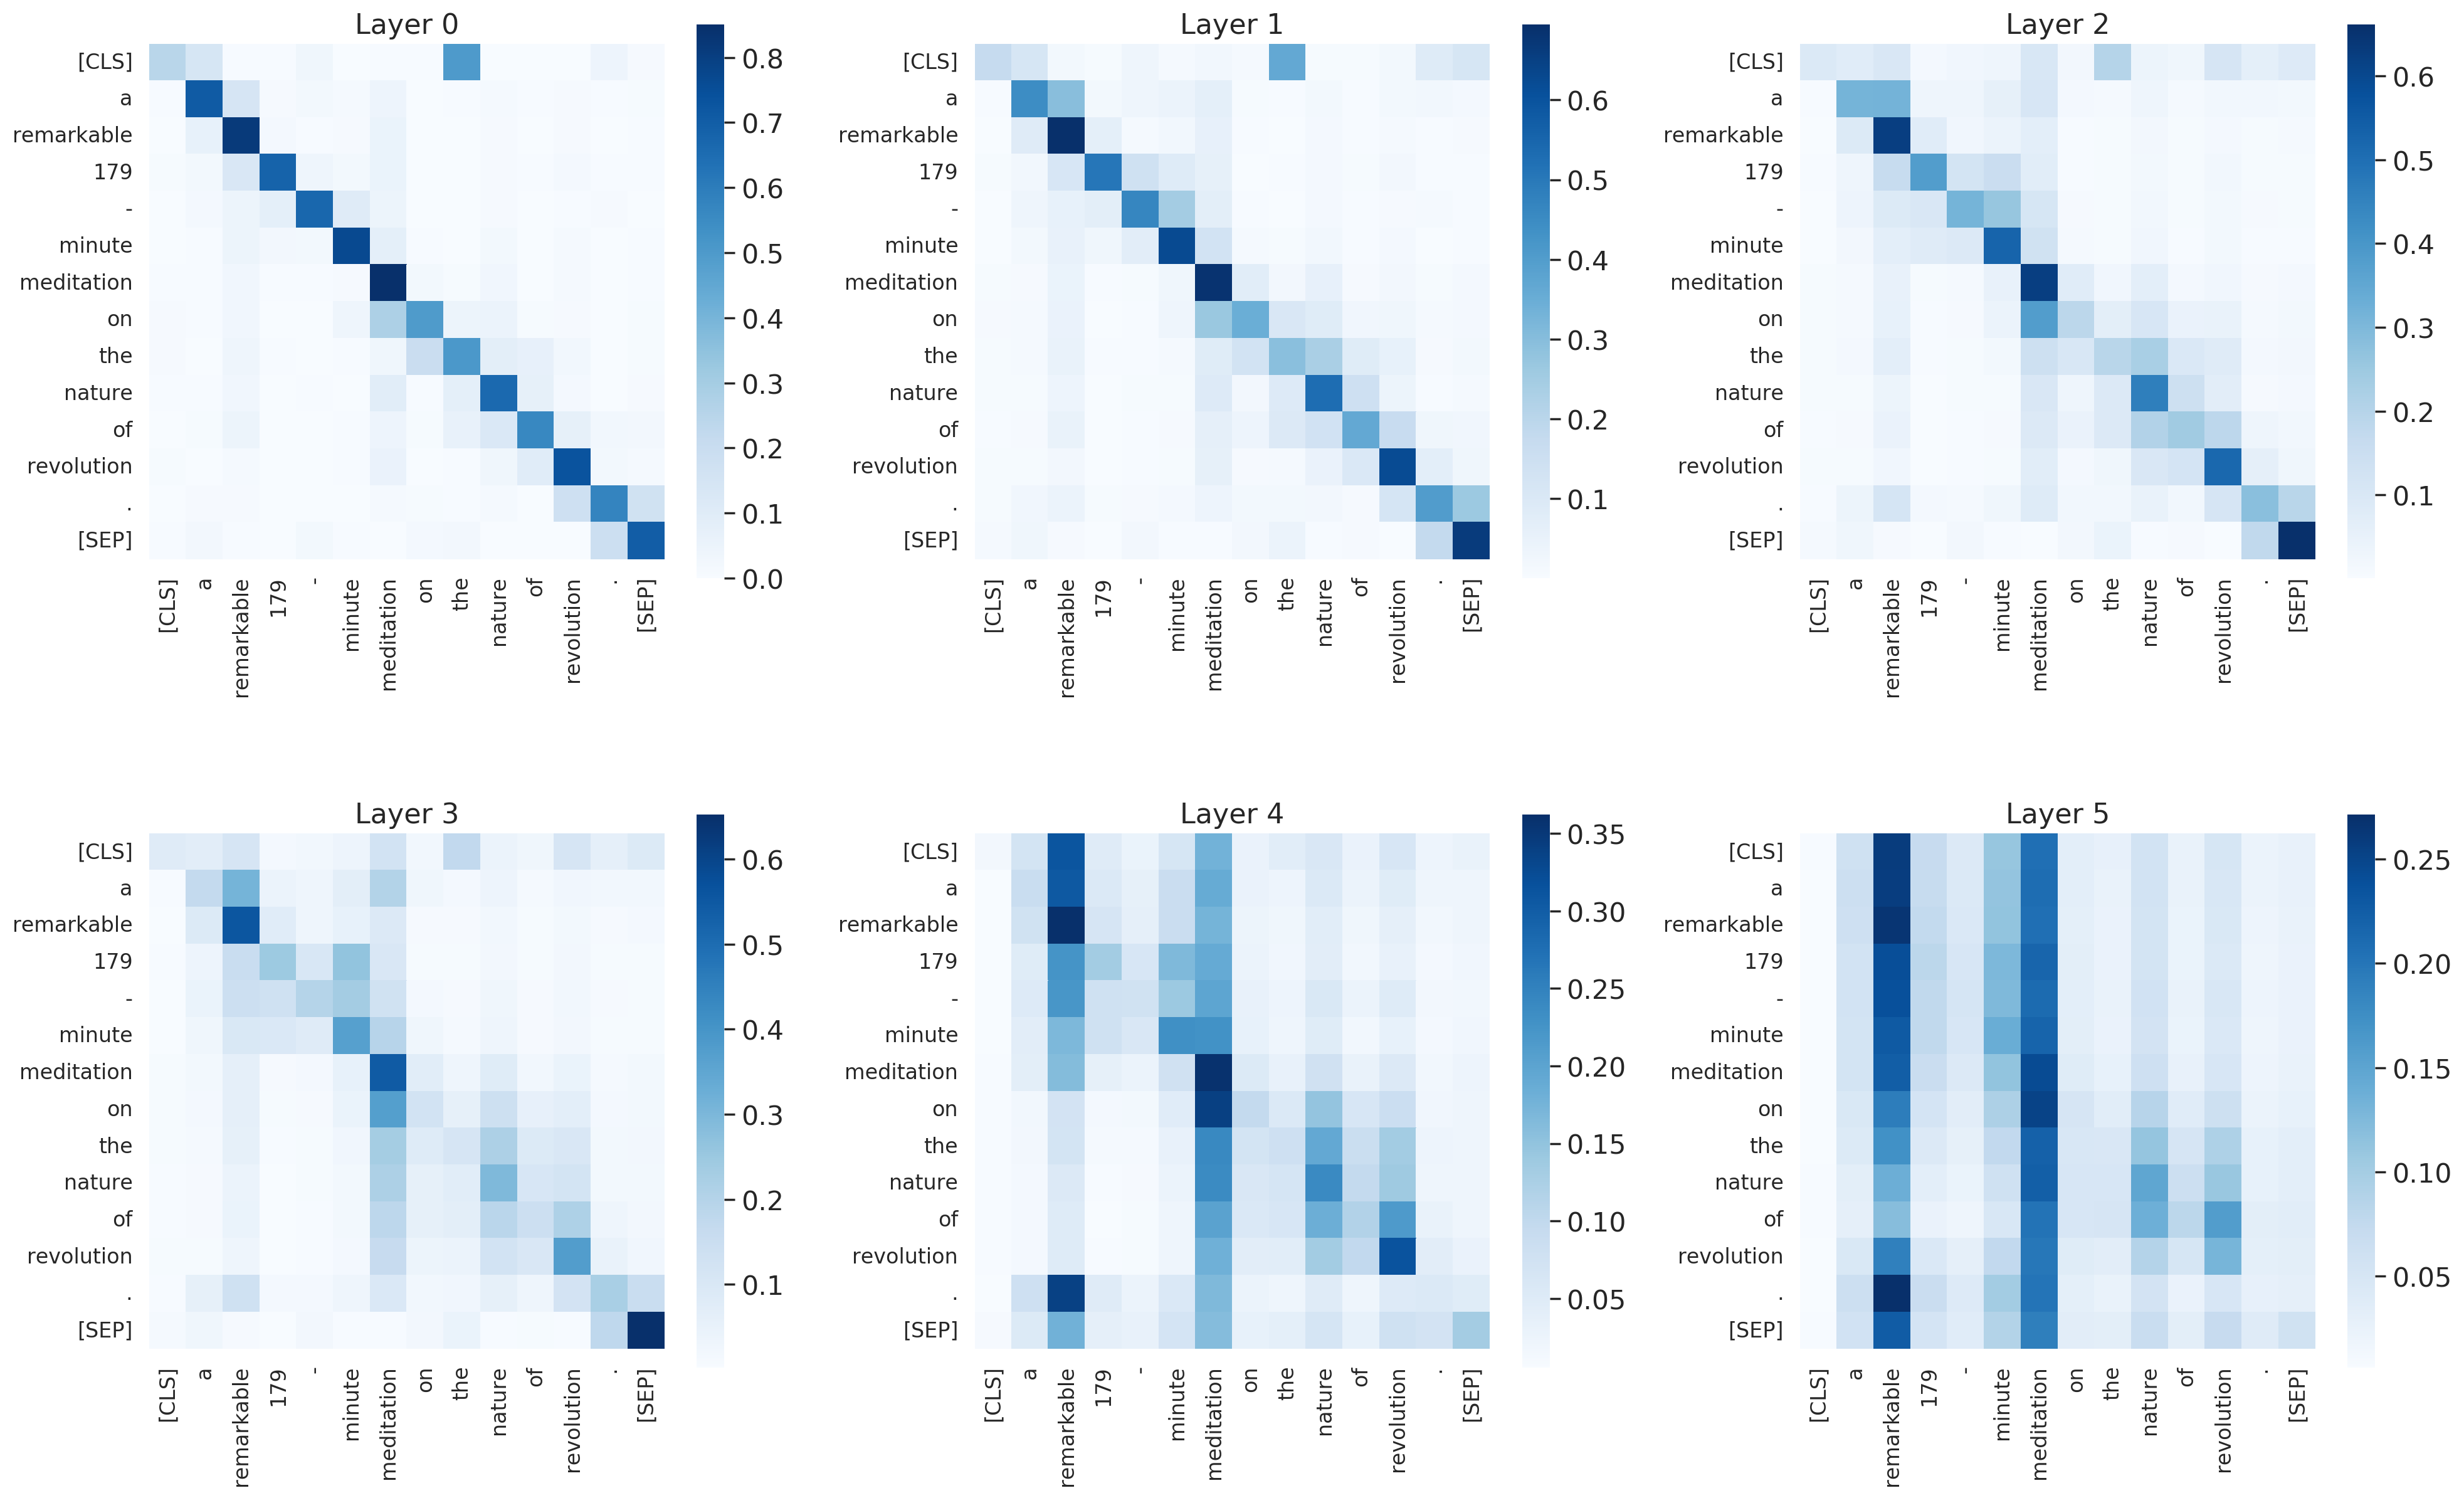

In [31]:
try:
    num_layers = model.config.num_hidden_layers
except:
    num_layers = model.config.n_layers

if num_layers == 12:
    fig, axs = plt.subplots(3, 4,figsize=(25,19), dpi=200,sharey=False)
    row = 4
    col = 4
elif num_layers == 6:
    fig, axs = plt.subplots(2, 3,figsize=(20,13), dpi=200,sharey=False)
    row = 3
    col = 3

for layer in range(0,num_layers):
    df = pd.DataFrame(contributions_mix[layer],columns=tokenized_text,index=tokenized_text)
    sns.heatmap(df,cmap="Blues",square=True,ax=axs[int(layer/row),layer%col],cbar_kws={'shrink': 0.8})
    #sns.set(font_scale=1)
    axs[int(layer/row),layer%col].set_title('Layer ' + str(layer),fontdict={'fontsize':16})
    axs[int(layer/row),layer%col].tick_params(axis='x', rotation=90)
    axs[int(layer/row),layer%col].set_xticklabels(axs[int(layer/row),layer%col].get_xmajorticklabels(), fontsize = 12)
    axs[int(layer/row),layer%col].set_yticklabels(axs[int(layer/row),layer%col].get_ymajorticklabels(), fontsize = 12)

fig.tight_layout()

## Other attribution methods with Captum

In [32]:
## https://github.com/pytorch/captum/issues/150
   
bert_model_wrapper = ClassificationModelWrapperCaptum(model)


grad_attributions, predicted_class = interpret_sentence_sst2(bert_model_wrapper, tokenizer, sentence=text, method='grad')
grad_input_attributions, predicted_class = interpret_sentence_sst2(bert_model_wrapper, tokenizer, sentence=text, method='grad_input')
grad_ig_attributions, predicted_class = interpret_sentence_sst2(bert_model_wrapper, tokenizer, sentence=text, method='ig')


In [33]:
# accumulate couple samples in this array for visualization purposes
vis_data_records_ig = []

def add_attributions_to_visualizer(attributions, tokens, pred, label, vis_data_records):
    attributions_min_max = normalize_attribution_visualization(attributions)
    attributions_min_max = attributions_min_max.cpu().detach().numpy()

    
    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions_min_max,
                            pred,
                            label,
                            label,
                            "label",
                            attributions_min_max.sum(),       
                            tokens[:len(attributions_min_max)],
                            0))
    return attributions_min_max

tokens = tokenizer.convert_ids_to_tokens(pt_batch["input_ids"][0].cpu().detach().numpy().tolist())
min_max_grad_attributions = add_attributions_to_visualizer(grad_attributions, tokens, pred, pred_ind, vis_data_records_ig)
min_max_grad_input_attributions = add_attributions_to_visualizer(grad_input_attributions, tokens, pred, pred_ind, vis_data_records_ig)
min_max_grad_ig_attributions = add_attributions_to_visualizer(grad_ig_attributions, tokens, pred, pred_ind, vis_data_records_ig)
min_max_joint_attention_rollout_cls = add_attributions_to_visualizer(joint_attention_rollout_cls, tokens, pred, pred_ind, vis_data_records_ig)
min_max_norm_rollout_cls = add_attributions_to_visualizer(norm_rollout_cls, tokens, pred, pred_ind, vis_data_records_ig)
min_max_contributions_mix_cls = add_attributions_to_visualizer(contributions_mix_cls, tokens, pred, pred_ind, vis_data_records_ig)

visualization.visualize_text(vis_data_records_ig);

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,1 (1.00),label,5.09,[CLS] a remarkable 179 - minute meditation on the nature of revolution . [SEP]
1,1 (1.00),label,4.00,[CLS] a remarkable 179 - minute meditation on the nature of revolution . [SEP]
1,1 (1.00),label,3.75,[CLS] a remarkable 179 - minute meditation on the nature of revolution . [SEP]
1,1 (1.00),label,2.37,[CLS] a remarkable 179 - minute meditation on the nature of revolution . [SEP]
1,1 (1.00),label,5.28,[CLS] a remarkable 179 - minute meditation on the nature of revolution . [SEP]
1,1 (1.00),label,3.55,[CLS] a remarkable 179 - minute meditation on the nature of revolution . [SEP]


## Prepare saliency maps for latex tables

In [34]:
attributions_list = []
attributions_list.append(min_max_grad_attributions)
attributions_list.append(min_max_grad_input_attributions)
attributions_list.append(min_max_grad_ig_attributions)
attributions_list.append(min_max_joint_attention_rollout_cls)
attributions_list.append(min_max_norm_rollout_cls)
attributions_list.append(min_max_contributions_mix_cls)
prepare_colorize()
methods_list = [0,1,2,3,4,5]
figure_saliency(attributions_list, tokenized_text, methods_list)


## Correlation between methods

In [3]:
!python src/correlations.py distilbert sst2 500

Loading distilbert ...
Loading sst2 ...
Reusing dataset glue (/home/usuaris/veu/javier.ferrando/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


## Analyzing isotropy

In [15]:
model_name = 'roberta'
dataset_name = 'sst2'
get_cos_mean(model_name,dataset_name)

Loading roberta ...
Loading sst2 ...


Reusing dataset glue (/home/usuaris/veu/javier.ferrando/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


In [3]:
import json
from matplotlib.lines import Line2D

plt.rcParams.update({'font.size': 16})
def visualize_transformed_space(model_names):
	"""Plot the baseline charts in the paper. Images are written to the img/ subfolder."""
	plt.figure(figsize=(12,4),dpi=200)
	#icons = [ 'ro:', 'bo:', 'go:']
	color = ['#82B366','#6C8EBF','#D79B00']

	for i, (model, num_layers) in enumerate([('distilbert', 6), ('bert', 12), ('roberta', 12)]):
		x = np.array(range(num_layers))
		data = json.load(open(f'cos_results/{model.lower()}_sst2_cos_results.json'))
		plt.plot(x, [ float(data["mean cosine similarity transformed vectors"][f'layer_{i}']) for i in x ], color[i], markersize=6, label=model_names[model], linewidth=2, linestyle='--',alpha = 1, marker='o')
		#plt.plot(x, [ float(data["mean cosine similarity embeddings"][f'layer_{i}']) for i in x ], icons[i], markersize=6, label=model, linewidth=2.5, alpha=0.65, linestyle='-')
		# print(spearmanr(
		# 	[ data["mean cosine similarity transformed vectors"][f'layer_{i}'] for i in x ],
		# 	[ data["word norm std"][f'layer_{i}'] for i in x ]
		# ))

	for i, spine in enumerate(plt.gca().spines.values()):
		if (i == 1) or (i==3):
			spine.set_visible(False)

	#plt.grid(False, linewidth=0.25)
	plt.legend(loc='upper left')
	plt.xlabel('Layer')
	plt.xticks(x)
	plt.ylim(0,1.0)
	plt.title("Cosine Similarity in Transformed Representations",fontsize='18')
	plt.savefig(f'img/sst2_mean_cosine_similarity_transformed.png', bbox_inches='tight')
	plt.close()

def visualize_embedding_space(model_names):
	"""Plot the baseline charts in the paper. Images are written to the img/ subfolder."""
    

	plt.figure(figsize=(12,4),dpi=200)
	#icons = [ 'ro:', 'bo:', 'go:']
	color = ['#82B366','#6C8EBF','#D79B00']

    

	for i, (model, num_layers) in enumerate([('distilbert', 7), ('bert', 13), ('roberta', 13)]):
        
		x = np.array(range(num_layers))
		data = json.load(open(f'cos_results/{model.lower()}_sst2_cos_results.json'))
		#plt.plot(x, [ float(data["mean cosine similarity transformed vectors"][f'layer_{i}']) for i in x ], icons[i], markersize=6, label=model, linewidth=2.5, alpha=0.65)
		plt.plot(x, [ float(data["mean cosine similarity embeddings"][f'layer_{i}']) for i in x ], color[i], markersize=6, label=model_names[model], linewidth=2, alpha=1,linestyle = '-',marker = 'o')
		# print(spearmanr(
		# 	[ data["mean cosine similarity transformed vectors"][f'layer_{i}'] for i in x ],
		# 	[ data["word norm std"][f'layer_{i}'] for i in x ]
		# ))

	for i, spine in enumerate(plt.gca().spines.values()):
		if (i == 1) or (i==3):
			spine.set_visible(False)

	#plt.grid(False, linewidth=0.25)
	plt.legend(loc='upper left')
	plt.xlabel('Layer')
	plt.xticks(x)
	plt.ylim(0,1.0)
	plt.title("Cosine Similarity in Layer Representations",fontsize='18')
	plt.savefig(f'img/sst2_mean_cosine_similarity_embeddings.png', bbox_inches='tight')
	plt.close()

model_names = {'distilbert' : 'DistilBERT', 'bert': 'BERT', 'roberta': 'RoBERTa'}

def visualize_joint_space(model_names):
	"""Plot the baseline charts in the paper. Images are written to the img/ subfolder."""
	plt.figure(figsize=(10,4),dpi=200)
	#icons = [ 'ro:', 'bo:', 'go:']
	color = ['#82B366','#6C8EBF','#D79B00']
	legend_elements = [Line2D([0], [0], color=color[0], lw=2, label=model_names['distilbert']),
                   Line2D([0], [0], color=color[1], lw=2, label=model_names['bert']),
                   Line2D([0], [0], color=color[2], lw=2, label=model_names['roberta'])]


	for i, (model, num_layers) in enumerate([('distilbert', 7), ('bert', 13), ('roberta', 13)]):
		x = np.array(range(num_layers))
		x_transf = np.array(range(num_layers-1))
		data = json.load(open(f'cos_results/{model.lower()}_sst2_cos_results.json'))
		plt.plot(x_transf, [ float(data["mean cosine similarity transformed vectors"][f'layer_{i}']) for i in x_transf ], color[i], markersize=6, label=model_names[model] + ' (T)', linewidth=2, linestyle='--',alpha = 1, marker='o')
		plt.plot(x, [ float(data["mean cosine similarity embeddings"][f'layer_{i}']) for i in x ], color[i], markersize=6, label=model_names[model], linewidth=2.5, alpha=0.65, linestyle='-', marker='v')

	for i, spine in enumerate(plt.gca().spines.values()):
		if (i == 1) or (i==3):
			spine.set_visible(False)

	plt.grid(False, linewidth=0.25)
	#plt.legend(handles=legend_elements, loc='upper left')
	plt.legend(loc='best',prop={'size': 14})#upper left
	plt.xlabel('Layer')
	plt.xticks(x)
	plt.ylim(0,1.0)
	#plt.title("Average Cosine Similarity of Layer vs Transformed Representations",fontsize='18')
	plt.savefig(f'img/sst2_mean_cosine_similarity_transformed_joint.png', bbox_inches='tight')#transparent=True
	plt.show()
	plt.close()





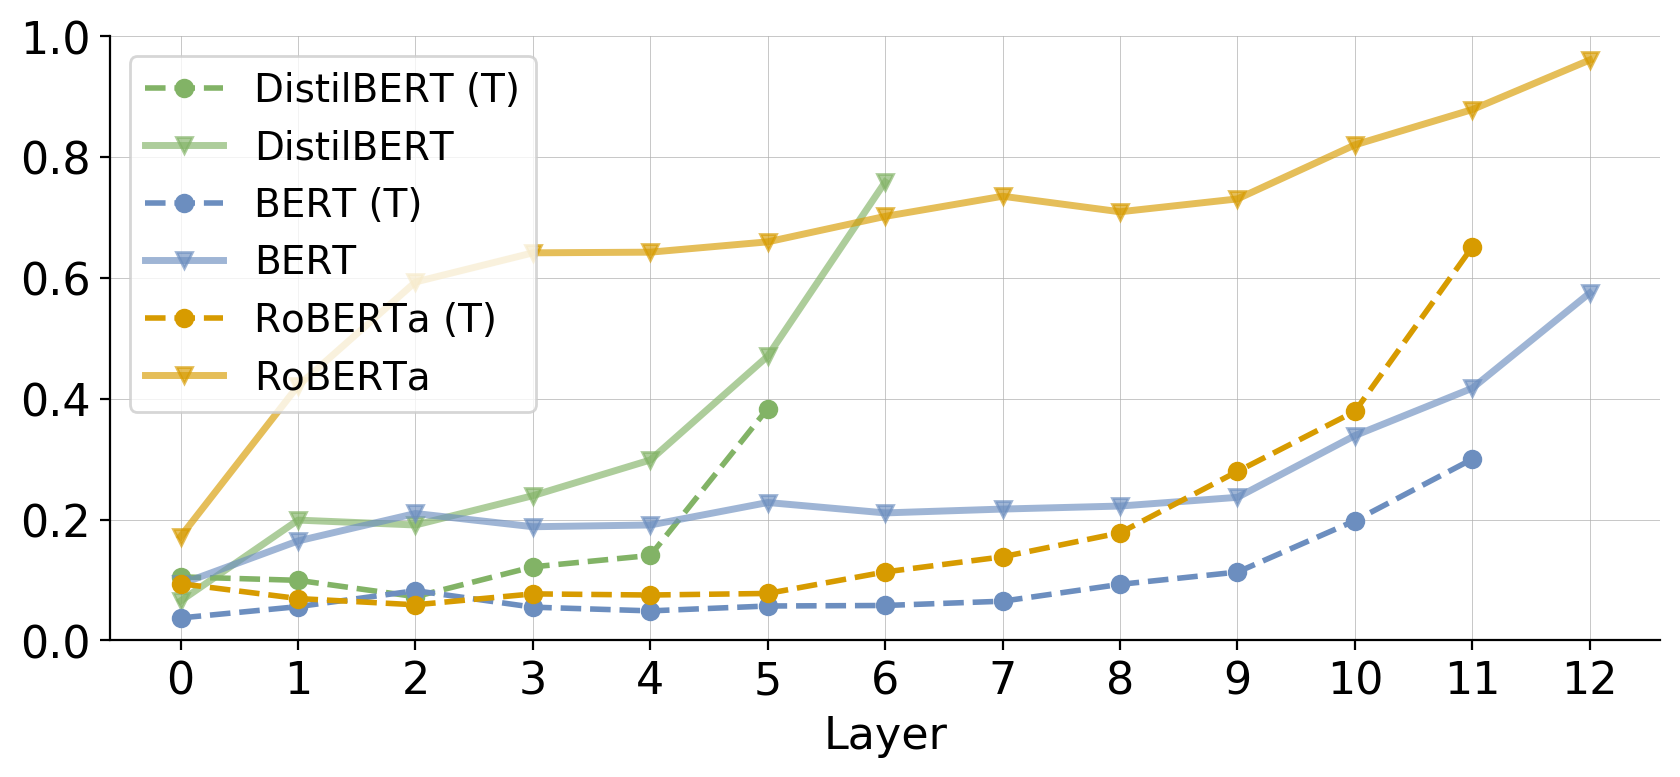

In [4]:
#visualize_transformed_space(model_names)
#visualize_embedding_space(model_names)
visualize_joint_space(model_names)

## Plot attribution to special tokens

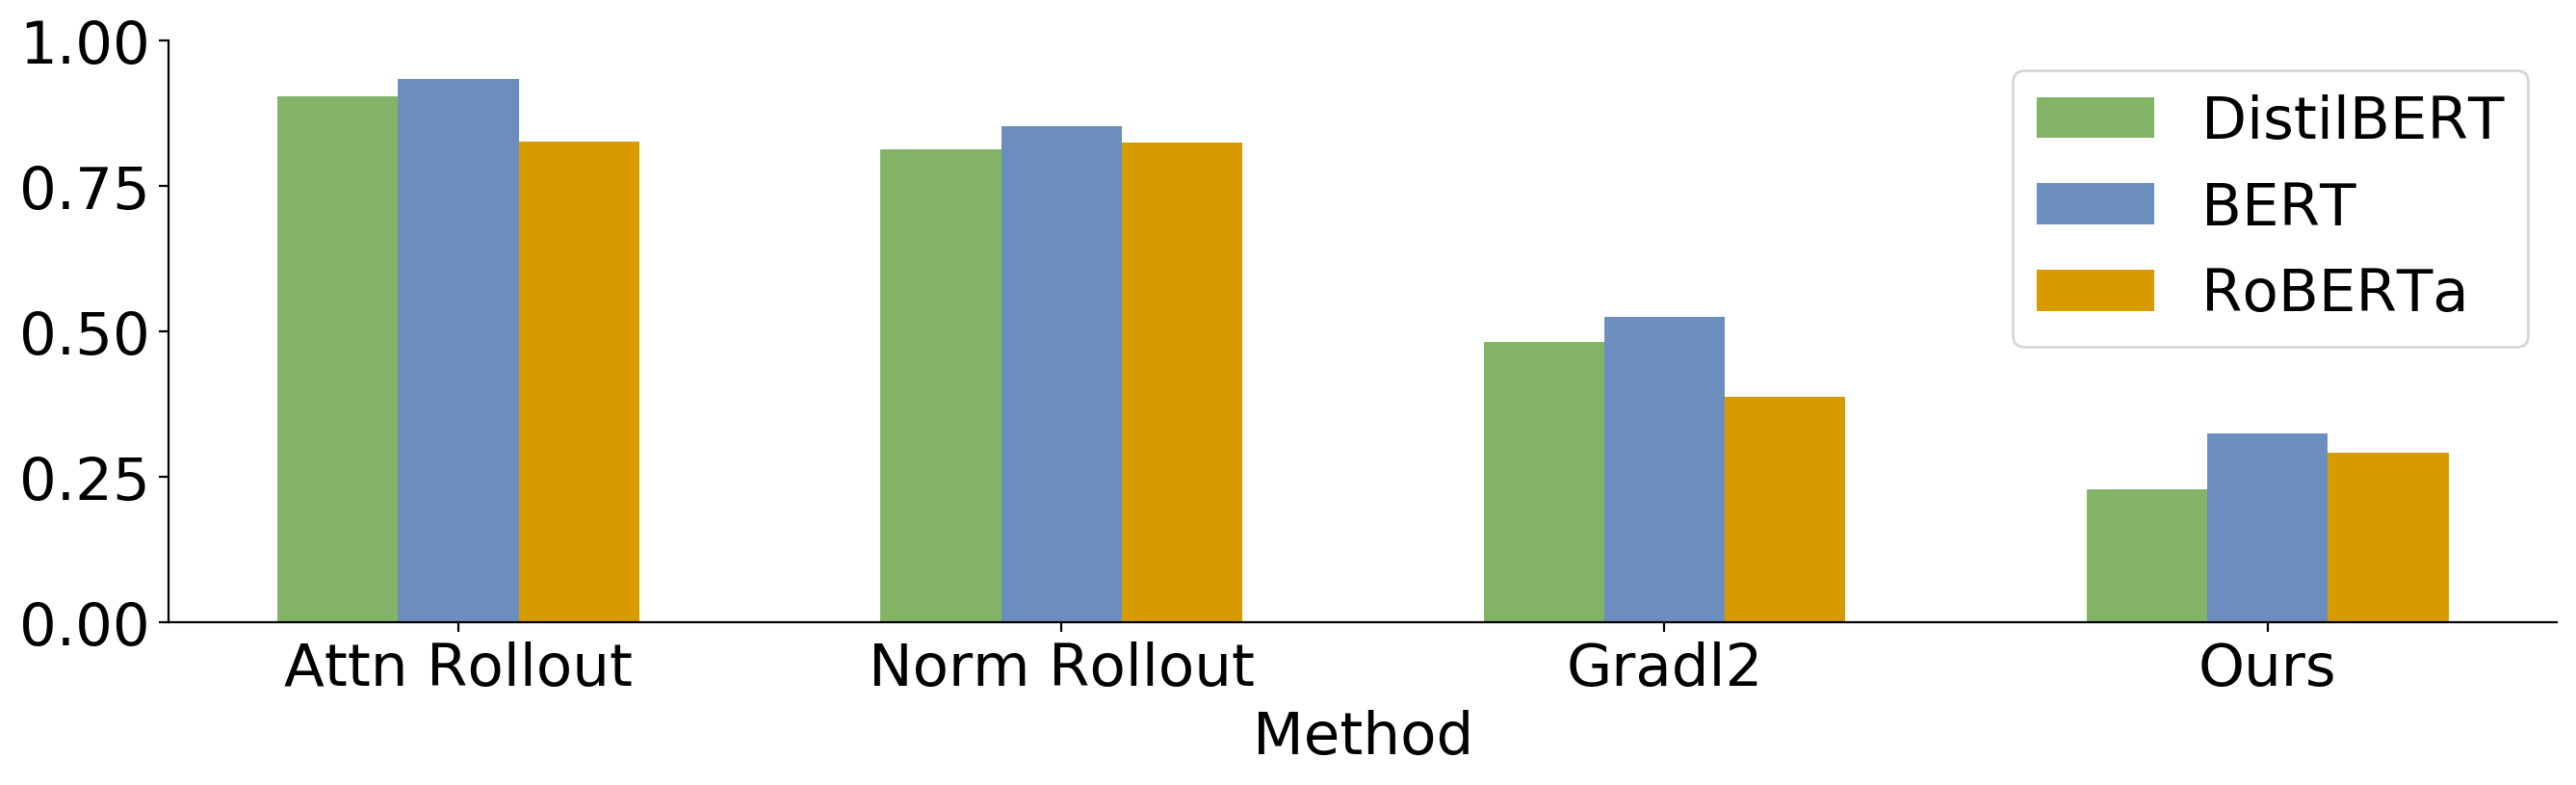

In [18]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(16,4),dpi=200)#
plt.rcParams.update({'font.size': 22})
model_names = {'distilbert' : 'DistilBERT', 'bert': 'BERT', 'roberta': 'RoBERTa'}
dataset_name = 'sst2'
labels = ['Attn Rollout', 'Norm Rollout', 'Gradl2', 'Ours']
color = ['#82B366','#6C8EBF','#D79B00']
pos = [-0.3,-0.1,0.1,0.3]
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

for i, model_ in enumerate(model_names):
    values = []
    data =  json.load(open(f'./data/{model_}_{dataset_name}_rank_special_tokens.json'))
    values.append(data['rollout'][0])
    values.append(data['rollout_norm'][0])
    values.append(data['grad'][0])
    values.append(data['our'][0])

    plt.bar(x + pos[i], values, width,color=color[i] ,label=model_names[model_])


#plt.title("Average attribution scores to special tokens",fontsize='18')
plt.xlabel('Method')
plt.xticks(x-0.1,labels)
plt.ylim(0,1.0)
plt.legend(loc='upper right')
for i, spine in enumerate(plt.gca().spines.values()):
    if (i == 1) or (i==3):
        spine.set_visible(False)
plt.savefig(f'img/attributions_special_tokens.png', bbox_inches='tight')
plt.show()
plt.close()

#plt.show()

## Consistency BERT and DistilBERT

Check for each method its ranked importances in BERT vs DistilBERT

In [13]:
bert_file = f'./data/sentences_bert_sst2_rank_relevancies.npy'
distilbert_file = f'./data/sentences_distilbert_sst2_rank_relevancies.npy'
bert_data = np.load(bert_file,allow_pickle=True)[()]
distilbert_data = np.load(distilbert_file,allow_pickle=True)[()]

In [5]:
i = 110
bert_data['pred_class'][i] == distilbert_data['pred_class'][i]

True

In [14]:
methods_list = ['raw','ours','grad','grad_input','ig']
results_corr = {}
counter = 0
for method in methods_list:
    if method == 'pred_class':
        pass
    results_corr[method] = []
    results_corr_tmp = []
    for i in range(len(bert_data['examples'])):
        # check for same tokenization
        bert_data_example = bert_data['examples'][i]
        distilbert_data_example = distilbert_data['examples'][i]
        if bert_data_example == distilbert_data_example:
            if bert_data['pred_class'][i] == distilbert_data['pred_class'][i]:
                counter += 1
                # print(bert_data_example)
                # print(distilbert_data_example)
                bert_data_rank_ex = get_normalized_rank(np.asarray(bert_data[method][i]))
                distilbert_data_rank_ex = get_normalized_rank(np.asarray(distilbert_data[method][i]))
                sp = spearmanr(bert_data_rank_ex,distilbert_data_rank_ex)
                results_corr_tmp.append(sp[0])
    

    print(f'{method}')
    print(np.mean(results_corr_tmp), np.std(results_corr_tmp))
    results_corr[method] = np.mean(results_corr_tmp)
    print(f'{counter} total results')

raw
0.5247801820656217 0.2672604923942747
468 total results
ours
0.786262993980854 0.10845417508944018
936 total results
grad
0.6467865436218838 0.17491365666882983
1404 total results
grad_input
0.07834414073281663 0.23566247576352306
1872 total results
ig
0.4436076691546144 0.19154356636473083
2340 total results


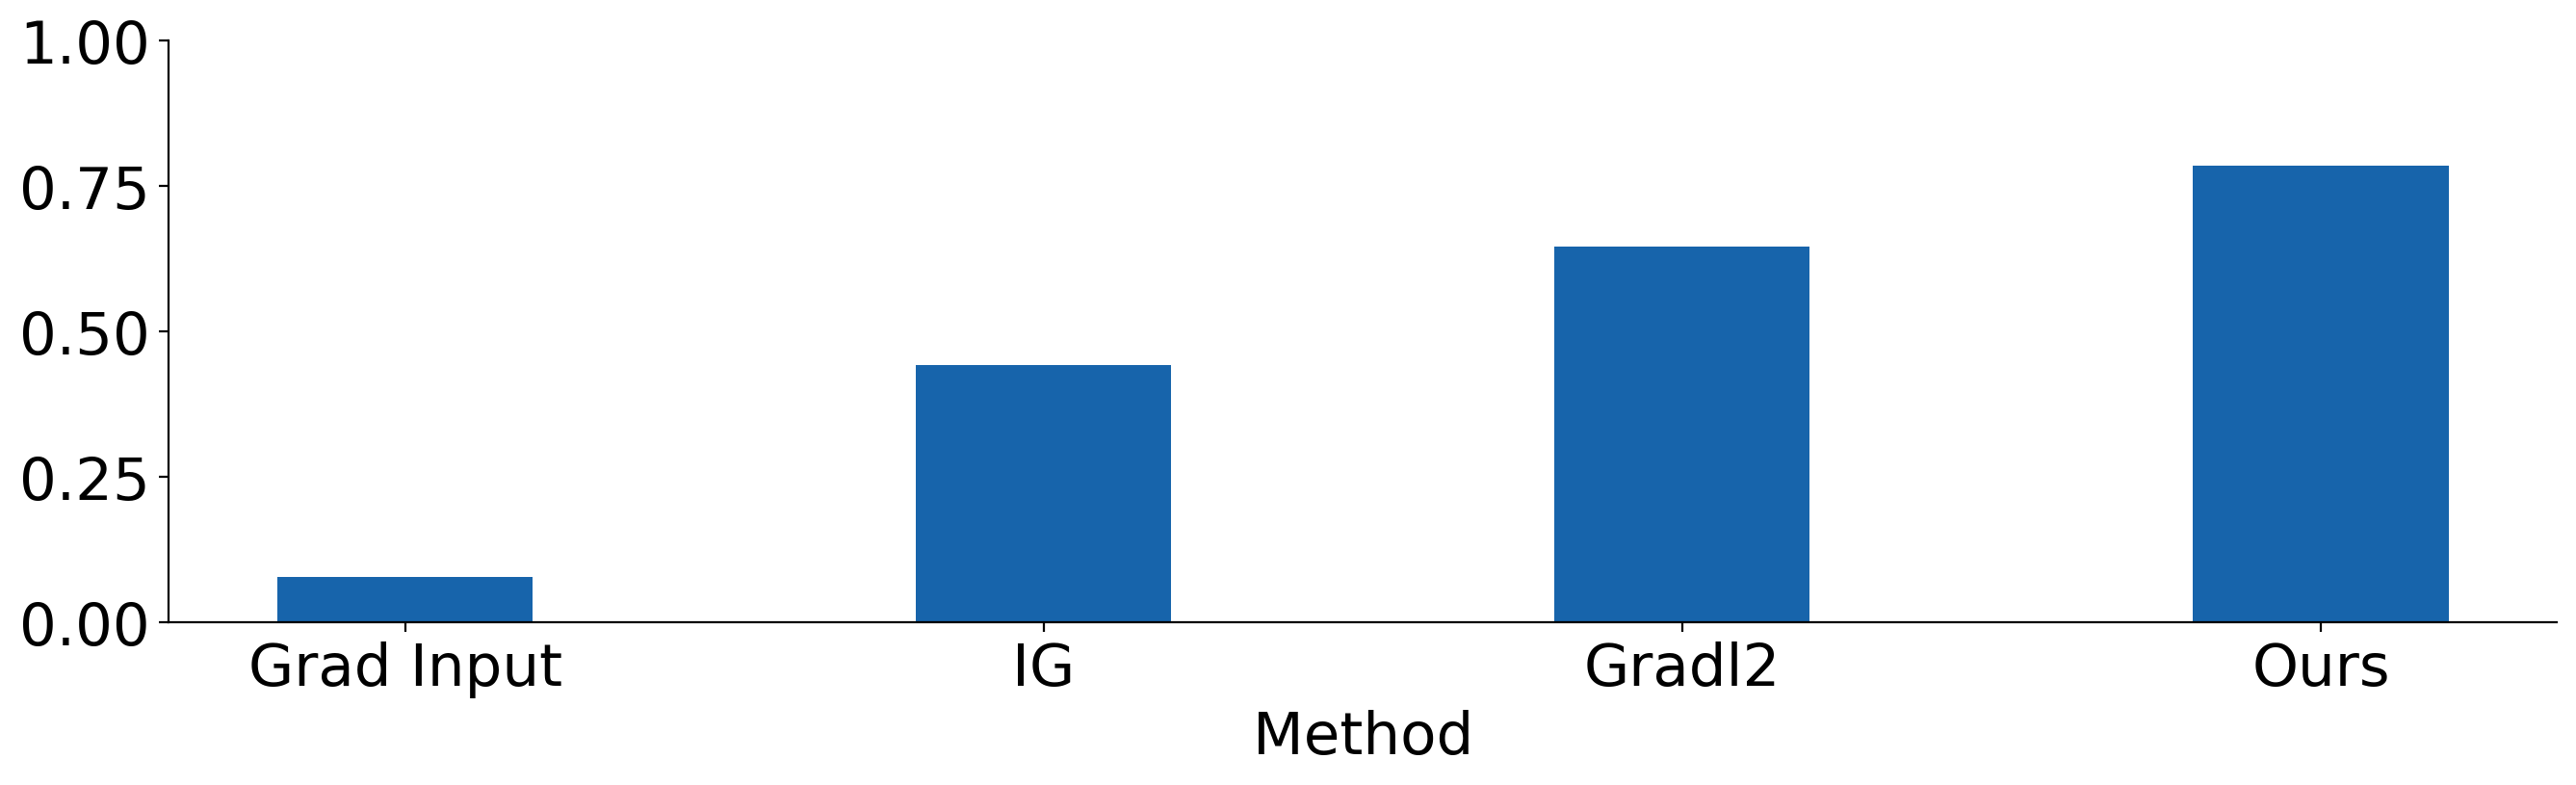

In [17]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(16,4),dpi=200)#
plt.rcParams.update({'font.size': 22})
method_names = {'grad_input' : 'Grad Input', 'ig': 'IG', 'grad': 'Gradl2', 'ours': 'Ours'}
labels = ['Grad Input', 'IG', 'Gradl2','Ours']
color = ['#0066CC','#B3B3B3','#B9E0A5','#CC0000']
#pos = [-0.3,-0.1,0.1,0.3]
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars
values = []
for i, method in enumerate(method_names):
    data =  results_corr[method]
    values.append(data)

plt.bar(x, values, width,color='#1764AB')


#plt.title("Average attribution scores to special tokens",fontsize='18')
plt.xlabel('Method')
plt.xticks(x,labels)
plt.ylim(0,1.0)
#plt.legend(labels=list(method_names.values()),loc='upper left')
for i, spine in enumerate(plt.gca().spines.values()):
    if (i == 1) or (i==3):
        spine.set_visible(False)
plt.savefig(f'img/model_consistency.png', bbox_inches='tight')
plt.show()
plt.close()

#plt.show()